In [2]:
import sys
sys.path.append('/workspace/ml/RAdam/')

import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import pandas as pd
import pandas_profiling
import numpy as np

import radam

F = nn.functional

%matplotlib inline

In [3]:
DATA_FILE = '/storage/MEGASync/Jupyter/event_dispatcher.csv'

### data generating

event props:

- priority: 1 = low (send later), 2 = normal (send if possible), 3 = hight (send immedialtely)
- frequency: times of happening within 5'
- duration: duration since last sending

rules:

- always send if `priority` == 3
- else only send if duration > 30' and frequency > 2



In [4]:
torch.arange(0, 30, 0.5).view(10, 6)

tensor([[ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000],
        [ 3.0000,  3.5000,  4.0000,  4.5000,  5.0000,  5.5000],
        [ 6.0000,  6.5000,  7.0000,  7.5000,  8.0000,  8.5000],
        [ 9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000],
        [12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000],
        [15.0000, 15.5000, 16.0000, 16.5000, 17.0000, 17.5000],
        [18.0000, 18.5000, 19.0000, 19.5000, 20.0000, 20.5000],
        [21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000],
        [24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000],
        [27.0000, 27.5000, 28.0000, 28.5000, 29.0000, 29.5000]])

In [5]:
def build_data(count=100):
    arr = []
    while len(arr) < count:
        priority = random.randint(0, 3)
        frequency = random.randint(0, 5)
        duration = random.randint(0, 60)
        label = 0
        if (priority == 3 or frequency > 2) and duration > 30:
            label = 1

        sample = [
            priority,
            frequency,
            duration,
            label
        ]
        arr.append(sample)
    return arr


if not os.path.exists(DATA_FILE):
    samples = build_data(10000)
    k = 0
    for c in samples:
        if k < 10:
            k += 1
            print(f'sample: {c[0:3]} --> label: {c[3]}')
            print(type(c[3]))

    headers = [
        'Priority',
        'Frequency',
        'Duration',
        'Label'
    ]
    df = pd.DataFrame(samples, columns=headers)
    df.to_csv(DATA_FILE, index=False)

else:
    df = pd.read_csv(DATA_FILE)

In [6]:
L = df.count()
L0 = df[df.Label == 0].count()
L1 = df[df.Label == 1].count()
print(f'Total {L.Label} samples, in which L0 = {L0.Label}, L1 = {L1.Label}')
print('*' * 50)
print('Take a look at random 10 items:')
df.sample(10)

Total 10000 samples, in which L0 = 6839, L1 = 3161
**************************************************
Take a look at random 10 items:


Priority  Frequency  Duration  Label
5614         1          5        13      0
7961         2          0        41      0
5376         1          0        11      0
8509         2          1        30      0
9871         0          0        57      0
3307         0          2        23      0
1794         2          5        34      1
4132         3          0        53      1
2132         1          3        34      1
8921         3          3        24      0

In [7]:
df.profile_report()

In [25]:
class SampleSet(Dataset):

    def __init__(self, data, transform=None):
        self.samples = data
        self.transform = transform

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = self.samples[idx]

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return len(self.samples)


    
def normalize(data):
    print(data[0:3])
    

def transform(item):
    a = torch.tensor(item[0:3], dtype=torch.float32)
    b = torch.tensor(item[3], dtype=torch.float32)
    return (a, b)

train_dataset = SampleSet(normalize(df.values), transform)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=False, num_workers=4)

[[ 1  0 16  0]
 [ 1  5 22  0]
 [ 3  1 18  0]]


In [9]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 9)
        self.fc2 = nn.Linear(9, 18)
        self.fc3 = nn.Linear(18, 6)
        self.fc4 = nn.Linear(6, 3)
        self.fc5 = nn.Linear(3, 1)
    
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = torch.sigmoid(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    

In [10]:
model = Net()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

# move model to the right device
model.to(device)

cuda


Net(
  (fc1): Linear(in_features=3, out_features=9, bias=True)
  (fc2): Linear(in_features=9, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=6, bias=True)
  (fc4): Linear(in_features=6, out_features=3, bias=True)
  (fc5): Linear(in_features=3, out_features=1, bias=True)
)

In [11]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = radam.RAdam(model.parameters(), lr=learning_rate)

In [12]:
# How many time the model will learn through the dataset
EPOCHS = 300
epoch_list = []
epoch_loss_list = []

for epoch in range(EPOCHS):
    epoch_list.append(epoch)
    
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.view(-1, 1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    # statistics
    epoch_loss = running_loss / len(train_dataset)
    epoch_loss_list.append(epoch_loss)
    
    if epoch % 50 == 49:    
        print(f'Epoch: {epoch+1} Loss: {epoch_loss}')

print('Finished Training')

Epoch: 50 Loss: 0.087031030356884
Epoch: 100 Loss: 0.08614712610840797
Epoch: 150 Loss: 0.08623661234974861
Epoch: 200 Loss: 0.08583140455186367
Epoch: 250 Loss: 0.08556234911084175
Epoch: 300 Loss: 0.08556263051927089
Finished Training


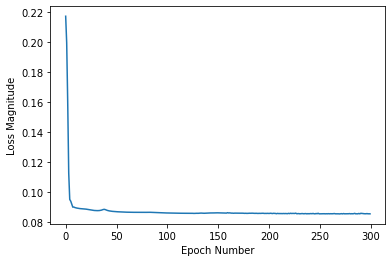

In [13]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(epoch_list, epoch_loss_list)